#AI VIET NAM
#RNN - LSTM

#**1. RNN**

In [2]:
import torch
import torch.nn as nn

torch.manual_seed(42)

In [3]:
batch_size = 1
seq_length = 3
embedding_dim = 3

input = torch.randint(
    high=2,
    size=(batch_size, seq_length, embedding_dim),
    dtype=torch.float32
)

input

tensor([[[0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 0.]]])

In [4]:
embedding_dim = 3
hidden_size = 2
activation = 'relu'

rnn_layer = nn.RNN(
    input_size=embedding_dim,
    hidden_size=hidden_size,
    nonlinearity=activation,
    batch_first=True
)

In [5]:
rnn_layer.all_weights

[[Parameter containing:
  tensor([[-0.5188,  0.6146,  0.1323],
          [ 0.5224,  0.0958,  0.3410]], requires_grad=True),
  Parameter containing:
  tensor([[-0.0998,  0.5451],
          [ 0.1045, -0.3301]], requires_grad=True),
  Parameter containing:
  tensor([ 0.1802, -0.3258], requires_grad=True),
  Parameter containing:
  tensor([-0.0829, -0.2872], requires_grad=True)]]

In [6]:
for param in rnn_layer.parameters():
    init_kernel_weight = torch.randint(
        high=2,
        size=(param.data.shape),
        dtype=torch.float32
    )
    param.data = init_kernel_weight

In [7]:
rnn_layer.all_weights

[[Parameter containing:
  tensor([[1., 1., 1.],
          [1., 1., 1.]], requires_grad=True),
  Parameter containing:
  tensor([[1., 0.],
          [0., 1.]], requires_grad=True),
  Parameter containing:
  tensor([1., 1.], requires_grad=True),
  Parameter containing:
  tensor([0., 1.], requires_grad=True)]]

**Example 1**

In [8]:
output, hn = rnn_layer(input)

In [9]:
output

tensor([[[2., 3.],
         [4., 6.],
         [5., 8.]]], grad_fn=<TransposeBackward1>)

In [10]:
hn

tensor([[[5., 8.]]], grad_fn=<StackBackward0>)

**Example 2**

In [11]:
h0 = torch.randint(
    high=2,
    size=(1, batch_size, hidden_size),
    dtype=torch.float32
)

In [12]:
h0

tensor([[[0., 0.]]])

In [13]:
output, hn = rnn_layer(input, h0)

In [14]:
output

tensor([[[2., 3.],
         [4., 6.],
         [5., 8.]]], grad_fn=<TransposeBackward1>)

In [15]:
hn

tensor([[[5., 8.]]], grad_fn=<StackBackward0>)

#**2. Text Classification Preprocessing**

###**2.1. Load Dataset**

In [16]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35
Receiving objects: 100% (39/39), 186.94 MiB | 15.78 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (11/11), done.


In [17]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31273.tx

In [18]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            if label == "pos":
                label = 1
            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [19]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

###**2.2. Preprocessing**

**Language Detection**

In [20]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=c57ed51ff05c2a6b43df6ac64849fdd0fdb19c392e14984d4afc164febeeca15
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [21]:
from langid.langid import LanguageIdentifier, model

def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

In [22]:
train_df_vi, train_df_other = identify_vn(train_df)

**Text Cleaning**

In [23]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [24]:
train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

<ipython-input-24-e21d2b59a2cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for index, row in train_df_vi.iterrows()]


###**2.3. Representation**

In [25]:
!pip install -q torchtext==0.16.0

In [26]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [27]:
# word-based tokenizer
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

In [28]:
# build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [29]:
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

###**2.4. Dataloader**

In [30]:
import torch

seq_length = 50

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence+([0]* (seq_length-len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

In [31]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [32]:
next(iter(train_dataloader))

(tensor([[   7,    6,   60,  ...,  180,  163,  360],
         [ 142,   66,   21,  ...,   20,   87,   53],
         [  22,    2,   19,  ...,    0,    0,    0],
         ...,
         [  74,  186,   11,  ...,   50,  421,  586],
         [   3,  278,   34,  ...,   89,  370,  331],
         [ 135,  969,  378,  ..., 2071,   97,   49]]),
 tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
         1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
         1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
         0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
         1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
         0, 1, 0, 1, 1, 0, 0, 1]))

In [33]:
len(train_dataloader)

233

In [34]:
encoded_sentences, labels = next(iter(train_dataloader))

In [35]:
encoded_sentences.shape

torch.Size([128, 50])

In [36]:
labels.shape

torch.Size([128])

###**2.5. Trainer**

In [37]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs, device)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [38]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs, device)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [39]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

In [40]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

#**3. RNN**

###**3.1. Modeling**

In [41]:
from torch import nn
from torch.nn import functional as F

embedding_dim = 200
hidden_size = 50

class RNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(RNNClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, X_batch, device):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(
            embeddings,
            torch.randn(1, len(X_batch), hidden_size).to(device)
        )
        output = self.linear(output[: , -1])
        return output

In [42]:
model = RNNClassifier(num_classes=2)

In [43]:
predictions = model(encoded_sentences, device='cpu')

In [44]:
predictions.shape

torch.Size([128, 2])

###**3.2. Training**

In [45]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNClassifier(num_classes=2)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  233 batches | accuracy    0.506
| epoch   1 |   100/  233 batches | accuracy    0.514
| epoch   1 |   150/  233 batches | accuracy    0.502
| epoch   1 |   200/  233 batches | accuracy    0.523
-----------------------------------------------------------
| End of epoch   1 | Time:  2.92s | Train Accuracy    0.519 | Train Loss    0.712 | Valid Accuracy    0.516 | Valid Loss    0.704 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.527
| epoch   2 |   100/  233 batches | accuracy    0.517
| epoch   2 |   150/  233 batches | accuracy    0.537
| epoch   2 |   200/  233 batches | accuracy    0.524
-----------------------------------------------------------
| End of epoch   2 | Time:  1.28s | Train Accuracy    0.533 | Train Loss    0.695 | Valid Accuracy    0.524 | Valid Loss    0.696 
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.547
| epoch   3 

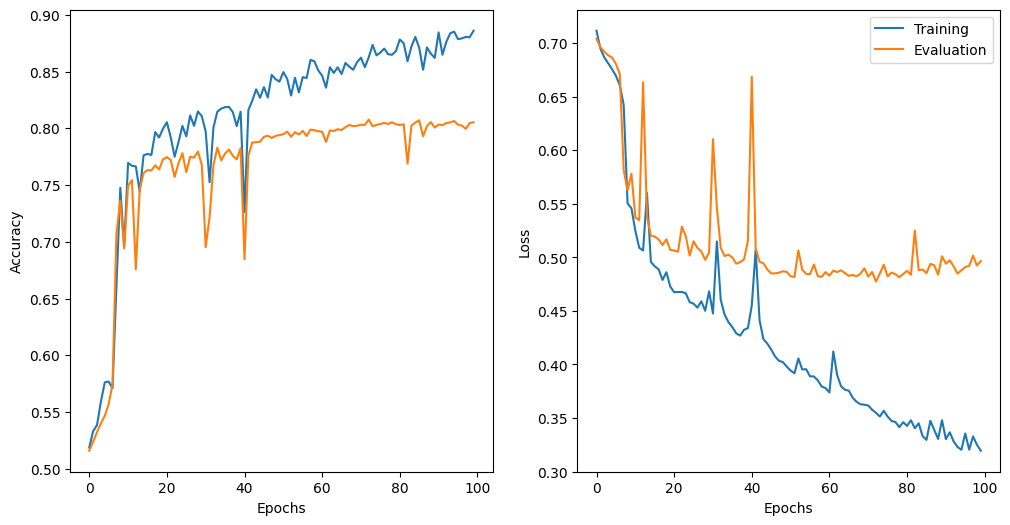

In [46]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [47]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.8092, 0.494980355984048)

#**4. LSTM**

###**4.1. Modeling**

In [51]:
from torch import nn
from torch.nn import functional as F

embedding_dim = 200
hidden_size = 50

class LSTMClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, X_batch, device):
        embeddings = self.embedding_layer(X_batch)
        output, (hidden, cell) = self.lstm(embeddings)
        output = self.linear(output[:, -1, :])
        return output

In [52]:
model = LSTMClassifier(num_classes=2)

In [53]:
predictions = model(encoded_sentences, device='cpu')

In [54]:
predictions.shape

torch.Size([128, 2])

###**4.2. Training**

In [55]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RNNClassifier(num_classes=2)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
save_model = './model'
os.makedirs(save_model, exist_ok = True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  233 batches | accuracy    0.498
| epoch   1 |   100/  233 batches | accuracy    0.503
| epoch   1 |   150/  233 batches | accuracy    0.517
| epoch   1 |   200/  233 batches | accuracy    0.503
-----------------------------------------------------------
| End of epoch   1 | Time:  1.09s | Train Accuracy    0.518 | Train Loss    0.707 | Valid Accuracy    0.509 | Valid Loss    0.701 
-----------------------------------------------------------
| epoch   2 |    50/  233 batches | accuracy    0.521
| epoch   2 |   100/  233 batches | accuracy    0.532
| epoch   2 |   150/  233 batches | accuracy    0.516
| epoch   2 |   200/  233 batches | accuracy    0.525
-----------------------------------------------------------
| End of epoch   2 | Time:  1.05s | Train Accuracy    0.519 | Train Loss    0.695 | Valid Accuracy    0.514 | Valid Loss    0.695 
-----------------------------------------------------------
| epoch   3 |    50/  233 batches | accuracy    0.532
| epoch   3 

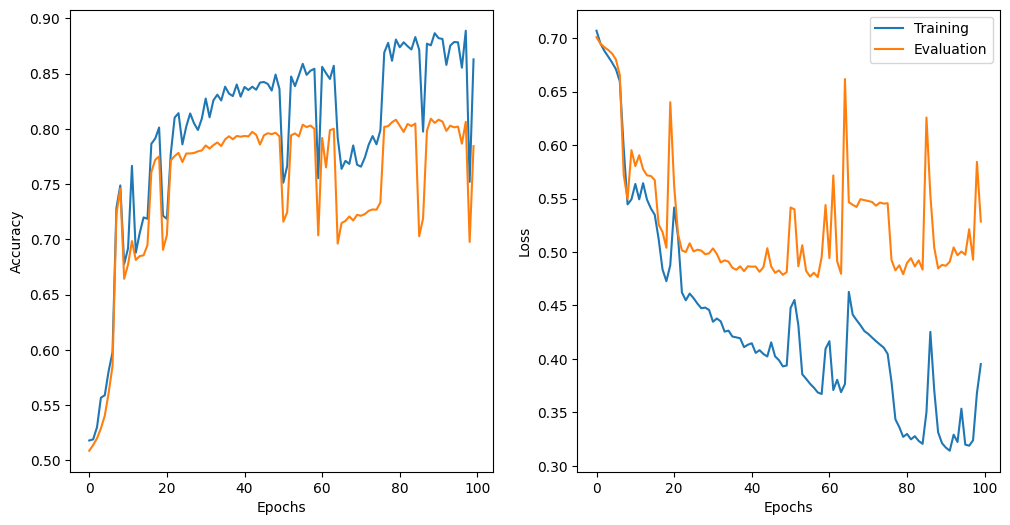

In [56]:
plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [57]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_dataloader, device)
test_acc, test_loss

(0.7845, 0.5317605352854426)